In [18]:
'''
"a" or "the" are interchangeable - transfer knowledge in this embedding space and generalize
through novel scenarios.


embedding space (27 characters into a 2d space)
can index with a list in pytorch

C[X], embed X at once

.view() - very efficient
.cat() - creates a new tensor and memory / inefficient
.storage()
tensor always 1-d vector in computer memory
.linspace


logit - very positive number, can result in range overflow (NAN)
offset logits, doesn't affect probs

benefits of cross entropy
- backprop and fwdprop are efficient
- don't run into anomalies with floating point nums.

do fward and backward prop on mini batches, to increase speed

learning rate decay (divide lr by 10)
model only learns based on training data

training, dev, test

'''

'\n"a" or "the" are interchangeable - transfer knowledge in this embedding space and generalize\nthrough novel scenarios.\n\n\nembedding space (27 characters into a 2d space)\ncan index with a list in pytorch\n\nC[X], embed X at once\n\n.view() - very efficient\n.cat() - creates a new tensor and memory / inefficient\n.storage()\ntensor always 1-d vector in computer memory\n.linspace\n\n\nlogit - very positive number, can result in range overflow (NAN)\noffset logits, doesn\'t affect probs\n\nbenefits of cross entropy\n- backprop and fwdprop are efficient\n- don\'t run into anomalies with floating point nums.\n\ndo fward and backward prop on mini batches, to increase speed\n\nlearning rate decay (divide lr by 10)\nmodel only learns based on training data\n\ntraining, dev, test\n\n'

In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [20]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [21]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [22]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [23]:
for p in parameters:
  p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10** lre

In [24]:
lri = []
lossi = []
stepi = []

In [25]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

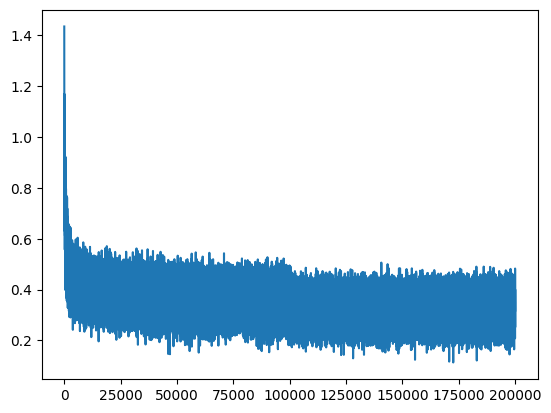

In [26]:
plt.plot(stepi, lossi)


In [28]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1300, grad_fn=<NllLossBackward0>)

In [ ]:
#Tune the hyperparameters of the training to beat my best validation loss of 2.2

